<a href="https://colab.research.google.com/github/sreeharshakv/PathMNIST-Classifier/blob/master/PathMNIST_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# More information on the dataset available on https://medmnist.com/
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117030 sha256=5edf044da8920bc8b413f21c2fcdc17ae880b101c0422136c1c8e3199118fee2
  Stored in directory: /root/.cache/pip/wheels/d6/6d/5d/5b73fa0f46d01a793713f8859201361e9e581ced8c75e5c6a3
Successfully built fire


In [3]:
import medmnist
from medmnist import INFO, Evaluator
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
info = INFO['pathmnist']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

size = 128 # possible values could be 28 or 128 or 224
train_data = DataClass(split='train', download=True, size=size)
val_data = DataClass(split='val', download=True, size=size)
test_data = DataClass(split='test', download=True, size=size)

train_data.info

100%|██████████| 4257786775/4257786775 [02:49<00:00, 25153954.95it/s]


Using downloaded and verified file: /root/.medmnist/pathmnist_128.npz
Using downloaded and verified file: /root/.medmnist/pathmnist_128.npz


{'python_class': 'PathMNIST',
 'description': 'The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.',
 'url': 'https://zenodo.org/records/10519652/files/pathmnist.npz?download=1',
 'MD5': 'a8b06965200029087d5bd730944a56c1',
 'url_64': 'https://zenodo.org/records/10519652/files/pathmnist_64.npz?download=1',
 'MD5_64': '55aa9c1e0525abe5a6b9d8343a507616',
 'url_128': 'https://zenodo.org/records/10519652/files/pathmnist_128.npz?download=1',
 'MD5

In [5]:
label_names = {int(k):v for k,v in train_data.info['label'].items()}

label_names

{0: 'adipose',
 1: 'background',
 2: 'debris',
 3: 'lymphocytes',
 4: 'mucus',
 5: 'smooth muscle',
 6: 'normal colon mucosa',
 7: 'cancer-associated stroma',
 8: 'colorectal adenocarcinoma epithelium'}

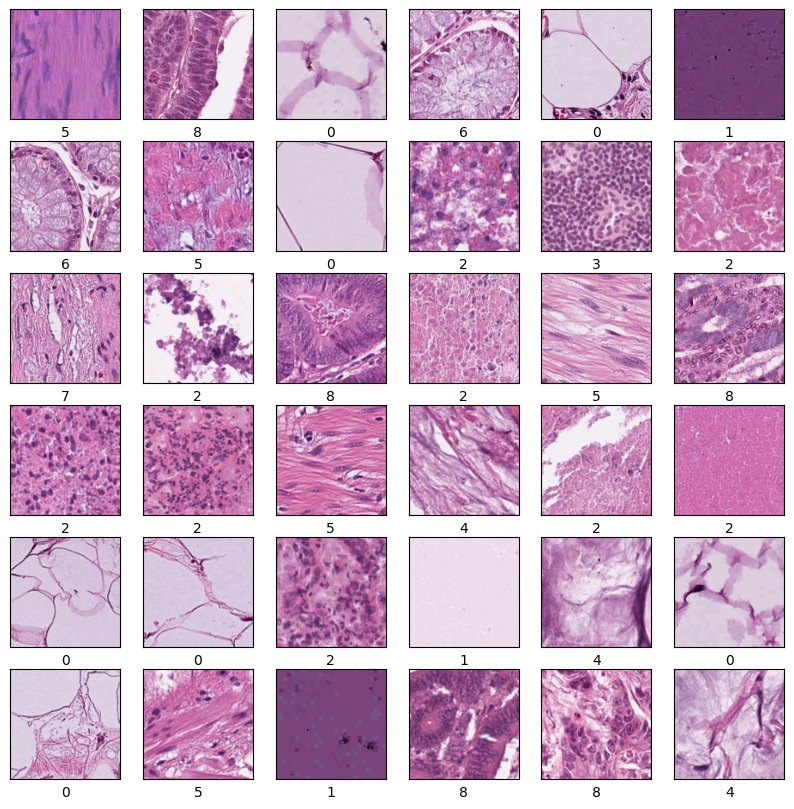

In [6]:
train_images, train_labels = train_data.imgs, train_data.labels

plt.figure(figsize=(10,10))
random_inds = np.random.choice(89996,36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(train_images[image_ind]), cmap=plt.cm.binary)
    plt.xlabel(train_labels[image_ind][0])

plt.show()

In [7]:
def preprocess(images, labels):
    images = images / 255.0  # Normalize to [0, 1]
    if images.ndim == 3:
        images = np.expand_dims(images, axis=-1)  # Add channel dimension
    labels = tf.keras.utils.to_categorical(labels, num_classes=n_classes)  # One-hot encoding
    return images, labels

# Prepare data
train_images, train_labels = preprocess(train_data.imgs, train_data.labels)
val_images, val_labels = preprocess(val_data.imgs, val_data.labels)
test_images, test_labels = preprocess(test_data.imgs, test_data.labels)

print(f"Train images shape: {train_images.shape}")
print(f"Validation images shape: {val_images.shape}")
print(f"Test images shape: {test_images.shape}")

Train images shape: (89996, 128, 128, 3)
Validation images shape: (10004, 128, 128, 3)
Test images shape: (7180, 128, 128, 3)


In [8]:
def build_cnn_model():
    cnn_model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D((2, 2)),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D((2, 2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(n_classes, activation='softmax')
])

    return cnn_model

cnn_model = build_cnn_model()

cnn_model.predict(train_images[[0]])

print(cnn_model.summary())

1/1 [==============================] - 0s 306ms/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2

In [9]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
history = cnn_model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=5, batch_size=64)

Epoch 1/5
1407/1407 [==============================] - 874s 620ms/step - loss: 0.7342 - accuracy: 0.7303 - val_loss: 0.3860 - val_accuracy: 0.8685
Epoch 2/5
1407/1407 [==============================] - 868s 617ms/step - loss: 0.2611 - accuracy: 0.9092 - val_loss: 0.3083 - val_accuracy: 0.9037
Epoch 3/5
1407/1407 [==============================] - 870s 618ms/step - loss: 0.1342 - accuracy: 0.9551 - val_loss: 0.1788 - val_accuracy: 0.9427
Epoch 4/5
1407/1407 [==============================] - 876s 623ms/step - loss: 0.0810 - accuracy: 0.9728 - val_loss: 0.1856 - val_accuracy: 0.9459
Epoch 5/5
1407/1407 [==============================] - 869s 618ms/step - loss: 0.0640 - accuracy: 0.9792 - val_loss: 0.2851 - val_accuracy: 0.9224


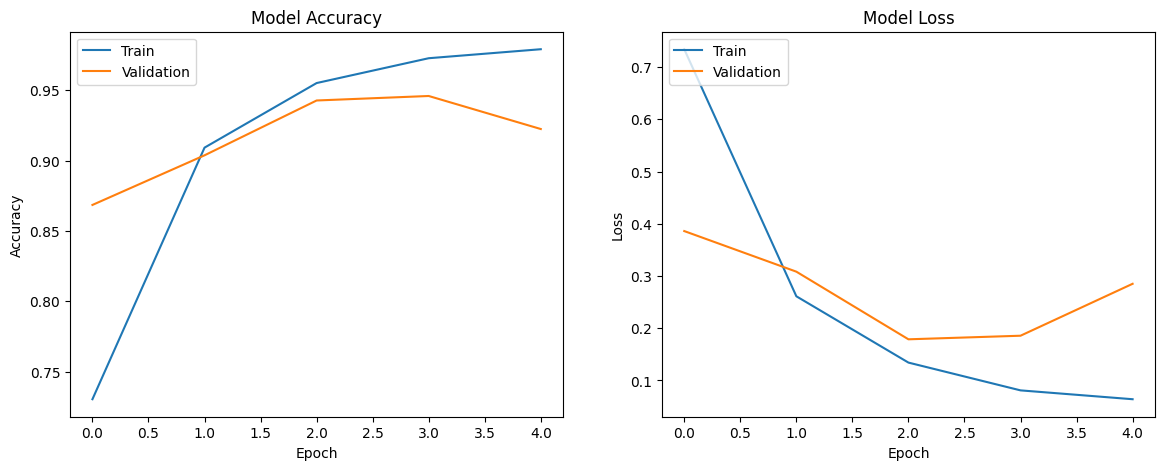

In [11]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [12]:
test_loss, test_acc = cnn_model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

225/225 [==============================] - 11s 50ms/step - loss: 0.5179 - accuracy: 0.8735
Test accuracy: 0.8735376000404358


In [13]:
predictions = cnn_model.predict(test_images)

225/225 [==============================] - 11s 50ms/step


Predicted Label: 8
True Label: 8


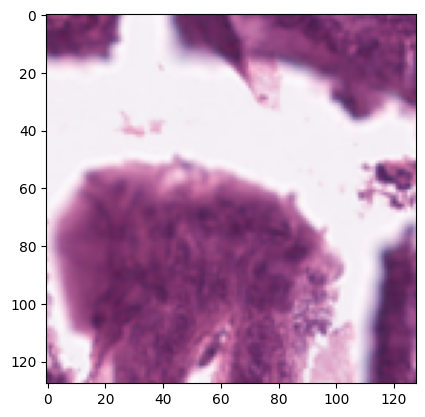

In [32]:
img_ind = 123  # Change this to the index of the image you want to visualize

plt.imshow(test_images[img_ind], cmap=plt.cm.binary)

predicted_label = np.argmax(predictions[img_ind])
test_label = np.argmax(test_labels[img_ind])

print("Predicted Label:", predicted_label)
print("True Label:", test_label)

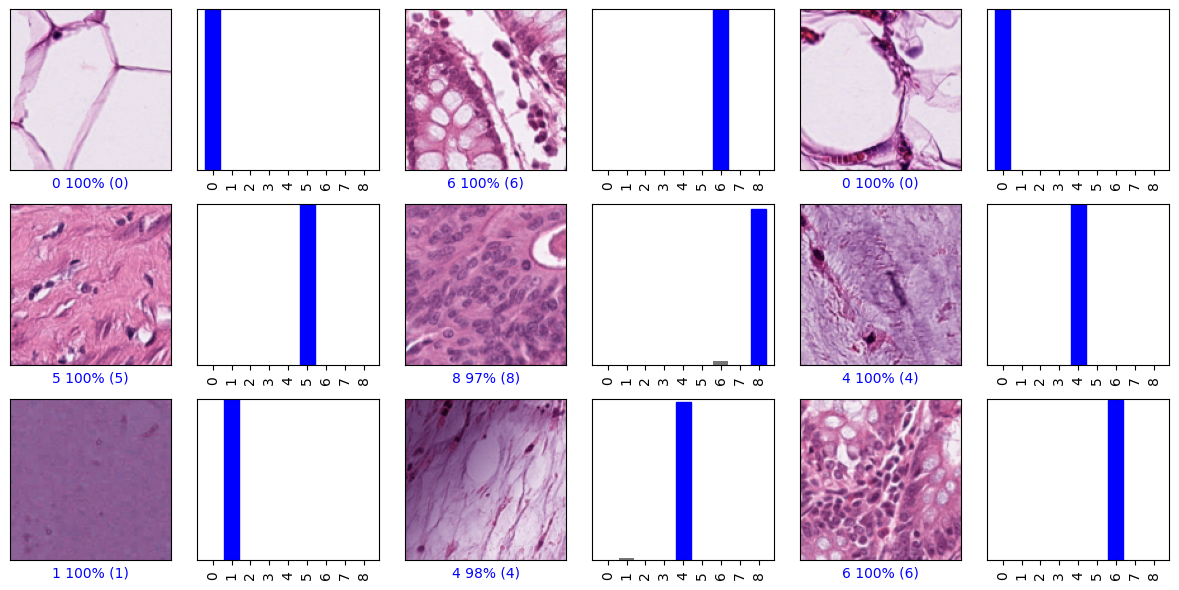

In [18]:
import random

num_rows = 3
num_cols = 3
num_images = num_rows * num_cols
random_indices = random.sample(range(len(test_images)), num_images)

plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i, idx in enumerate(random_indices):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_images[idx], cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions[idx])
    true_label = np.argmax(test_labels[idx])
    color = 'blue' if predicted_label == true_label else 'red'
    plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                         100*np.max(predictions[idx]),
                                         true_label),
                                         color=color)

    # Plot a bar graph for the class probabilities
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plt.grid(False)
    plt.xticks(range(len(predictions[idx])), rotation=90)
    plt.yticks([])
    thisplot = plt.bar(range(len(predictions[idx])), predictions[idx], color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions[idx])

    # Color the highest bar in red if the prediction is incorrect
    if predicted_label == true_label:
        thisplot[predicted_label].set_color('blue')
    else:
        thisplot[predicted_label].set_color('red')

plt.tight_layout()
plt.show()